In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

In [20]:
data_preprocessed = pd.read_csv("test-data/preprocessed.csv")

In [ ]:
X_text = data_preprocessed["cleaned_text"]
y_target = data_preprocessed["target"]

N_SPLITS = 5 
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
f1_scores = []
M = 0.001 # Minimum frequency threshold
total_conf_matrix = np.zeros((2, 2))

for i, (train_index, val_index) in enumerate(kf.split(X_text, y_target)):
    print(f"--- Processing Fold {i+1}/{N_SPLITS} ---")
    
    X_train_text, X_val_text = X_text.iloc[train_index], X_text.iloc[val_index]
    y_train, y_val = y_target.iloc[train_index], y_target.iloc[val_index]

    vectorizer = CountVectorizer(binary=True, min_df=M)
    
    X_train_features = vectorizer.fit_transform(X_train_text)
    X_val_features = vectorizer.transform(X_val_text)
    
    logreg_l2 = LogisticRegression(penalty="l2", solver="liblinear", random_state=42)
    model_logreg_l2 = logreg_l2.fit(X_train_features, y_train)
    
    y_pred = model_logreg_l2.predict(X_val_features)
    fold_f1 = f1_score(y_true=y_val, y_pred=y_pred)
    f1_scores.append(fold_f1)

    conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred)
    total_conf_matrix += conf_matrix

print(f"Individual F1-Scores: {f1_scores}")
print(f"Mean F1-Score across {N_SPLITS} folds: {np.mean(f1_scores):.4f}")
print(f"Standard Deviation of F1-Score: {np.std(f1_scores):.4f}")

211
--- Processing Fold 1/5 ---
--- Processing Fold 2/5 ---
--- Processing Fold 3/5 ---
--- Processing Fold 4/5 ---
--- Processing Fold 5/5 ---
Individual F1-Scores: [0.875, 0.8666666666666667, 0.8148148148148148, 0.9333333333333333, 0.782608695652174]
Mean F1-Score across 5 folds: 0.8545
Standard Deviation of F1-Score: 0.0520


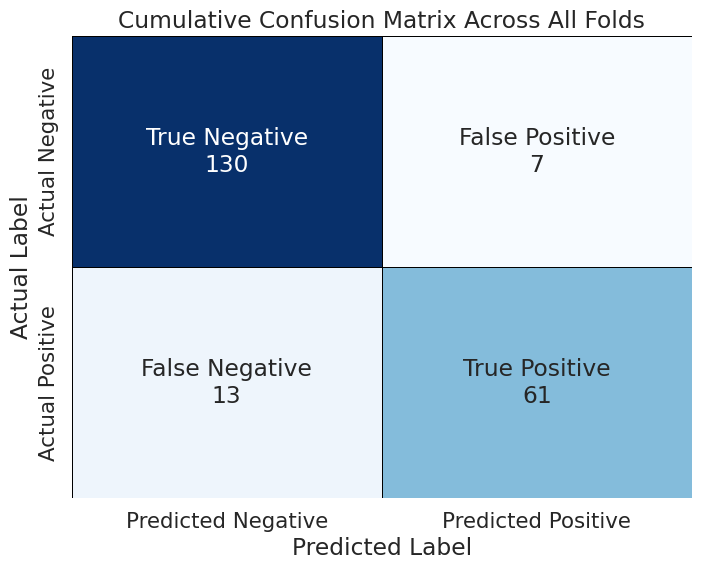

<Figure size 640x480 with 0 Axes>

In [25]:
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:g}".format(value) for value in total_conf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(8, 6))

sns.heatmap(
    total_conf_matrix, 
    annot=labels, 
    fmt="",
    cmap='Blues', 
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    xticklabels=['Predicted Negative', 'Predicted Positive'],
    yticklabels=['Actual Negative', 'Actual Positive']
)

plt.title('Cumulative Confusion Matrix Across All Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
plt.savefig('cumulative_confusion_matrix.png', bbox_inches='tight')

In [23]:
vectorizer = CountVectorizer(binary=True, min_df=M)
X_features = vectorizer.fit_transform(X_text)
model_logreg_l2 = LogisticRegression(penalty="l2", solver="liblinear", random_state=42)
final_model = model_logreg_l2.fit(X_features, y_target)

In [24]:
model_filename = 'models/trained_logistic_regression_model.pkl'
vectorizer_filename = 'models/trained_count_vectorizer.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(final_model, file)

with open(vectorizer_filename, 'wb') as file:
    pickle.dump(vectorizer, file)